In [50]:
%matplotlib inline 
import math 
import torch 
from torch import nn 
from torch.nn import functional as F 
from d2l import torch as d2l


In [51]:
batch_size, num_steps = 32,35
train_iter,vocab=d2l.load_data_time_machine(batch_size,num_steps)

In [52]:
F.one_hot(torch.tensor([0,2,3]),28),(F.one_hot(torch.tensor([0,2,3]),28)).shape
# len(vocab)

(tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]]),
 torch.Size([3, 28]))

In [53]:
X = torch.arange(10).reshape(2,5)
F.one_hot(X.T,28).shape

torch.Size([5, 2, 28])

#### 初始化模型参数

In [54]:
def get_params(vocab_size,num_hiddens,device):
    num_inputs = num_outputs = vocab_size 

    def normal(shape):
        return torch.randn(size=shape,device=device) * 0.01
    #隐藏层参数 X:1xd  W_xh:dxh H:nxh  
    W_xh = normal((num_inputs,num_hiddens))
    W_hh=normal((num_hiddens,num_hiddens))
    b_h=torch.zeros(num_hiddens,device=device)
    #输出层参数
    W_hq=normal((num_hiddens,num_outputs))
    b_q=torch.zeros(num_outputs,device=device)
    #附加梯度
    params = [W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params 

In [55]:
#定义一个函数在初始化时返回隐状态
def init_rnn_state(batch_size,num_hiddens,device):
    # return  (torch.zeros((batch_size,num_hiddens),device=device), )
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [56]:
#定义前向函数
def rnn(inputs,state,params):
    #inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh,W_hh,b_h,W_hq,b_q = params 
    H, = state
    outputs = []
    #X 的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X,W_xh)+torch.mm(H,W_hh)+b_h )
        Y = torch.mm(H,W_hq) + b_q 
        outputs.append(Y)
    return torch.cat(outputs,dim=0),(H,)

In [57]:
#创建一个类来包装这些函数
class RNNModelScratch:
    def __init__(self,vocab_size,num_hiddens,device,
                 get_params,init_state,forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size,num_hiddens 
        self.params=get_params(vocab_size,num_hiddens,device)
        self.init_state,self.forward_fn=init_state,forward_fn
    #对RNNModelScratch直接调用
    def __call__(self,X,state):
        X=F.one_hot(X.T,self.vocab_size).type(torch.float32)
        return self.forward_fn(X,state,self.params)
    
    def begin_state(self,batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)


In [58]:
num_hiddens = 512
net=RNNModelScratch(len(vocab),num_hiddens,d2l.try_gpu(),
                    get_params,
                    init_rnn_state,rnn)
state = net.begin_state(X.shape[0],d2l.try_gpu())
Y,new_state = net(X.to(d2l.try_gpu()),state)
Y.shape,len(new_state),new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

### ！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！

In [59]:
#预测
def predict_ch8(prefix,num_preds,net,vocab,device):
    """在prefix之后生成新的字符"""
    state = net.begin_state(batch_size=1,device=device)
    #下标
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]],device=device).reshape((1,1))
    for y in prefix[1:]:
        _,state = net(get_input(),state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y,state = net(get_input(),state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [60]:
predict_ch8("i am ",10,net,vocab ,d2l.try_gpu())

'i am t<unk>feqfeqfe'

In [61]:
#梯度剪裁
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm=torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:]*=theta/norm 

In [64]:
#训练
def train_epoch_ch8(net,train_iter,loss,updater,device,use_random_iter):
    state,timer = None,d2l.Timer()
    metric = d2l.Accumulator(2)
    for X,Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0],device=device)
        else:
            if isinstance(net,nn.Module) and not isinstance(state,tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y=Y.T.reshape(-1)
        X,y = X.to(device),y.to(device)
        y_hat,state = net(X,state)
        l=loss(y_hat,y.long()).mean()
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net,1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net,1)
            updater(batch_size=1)
        metric.add(l*y.numel(),y.numel())
    return math.exp(metric[0]/metric[1]),metric[1]/timer.stop()
            


perplexity 1.1, 144518.3 tokens/sec on cuda:0
time travellerit would be remarkably convenient for the historia
travelleryou can show black is white by argument said filby


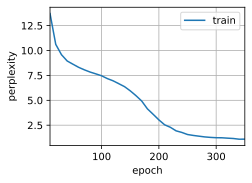

In [63]:
num_epochs,lr = 350,1
d2l.train_ch8(net,train_iter,vocab,lr,num_epochs,d2l.try_gpu())